
Model training with training data generated on the fly
=======================================================

This example demonstrates how to generate training data on the fly during training.
In some cases, data generation speed is fast enough to be used on the fly for model training. 

Here, the example demonstrates single source model training similar as in [Kuj19]_, but without simulation the time data (dataset2). Instead, the CSM is calculated from the Wishart distributed source power matrix $Q$.


## Build the dataset generator

At first, we manipulate the dataset config to only create single source examples on a smaller grid  of size $51 \times 51$

In [5]:
import os
import tensorflow as tf 
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # change tensorflow log level for doc purposes
from acoupipe import Dataset2

# training dataset
training = Dataset2(
        split="training",
        max_nsources = 1,
        size=100000,
        f=1000,
        features=["sourcemap"])
training.grid.increment = 1/50*training.mics.aperture

# validation dataset
validation = Dataset2(
        split="validation",
        max_nsources = 1,
        size=100,
        f=1000,
        features=["sourcemap"])
validation.grid.increment = 1/50*validation.mics.aperture


The TensorFlow dataset API can be used to build a data pipeline from the data generator. Here, batches with 32 source cases are used.

In [6]:

def yield_features_and_labels(dataset):
    for data in dataset.generate():
        feature = data['sourcemap'][0]
        f_max = feature.max()
        feature /= f_max
        label = np.concatenate([
            data['p2'][:,:,0,0]/f_max,
            data['loc'][:2]]).squeeze()
        yield (feature,label)

# signature of the generator
output_signature = (
                    tf.TensorSpec(shape=(51,51,1)),
                    tf.TensorSpec(shape=(3,)),
                    )

# build datasets for training and validation
training_dataset = tf.data.Dataset.from_generator(lambda: yield_features_and_labels(training),
                                         output_signature=output_signature)
validation_dataset = tf.data.Dataset.from_generator(lambda: yield_features_and_labels(validation),
                                         output_signature=output_signature)

training_dataset = training_dataset.batch(16).repeat()
validation_dataset = validation_dataset.batch(16)


Now, one can build the ResNet50V2 model and use the data to fit the model. This may take several hours, depending on the computational infrastructure. 

In [8]:
# build model architecture
model = tf.keras.Sequential(
    tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    weights=None,
    input_shape=(51,51,1),
    ))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation=None))

# compile and fit
model.compile(optimizer=tf.optimizers.Adam(1.5*10e-4),loss='mse')
model.fit(training_dataset,validation_data=validation_dataset, epochs=25,steps_per_epoch=1000, verbose=0)

  1%|          | 701/100000 [00:40<49:45, 33.26it/s]

After successfully training, the model can be used for source characteristic prediction.

 10%|█         | 10/100 [00:34<04:37,  3.09s/it]

1/1 [==============================] - 0s 30ms/step


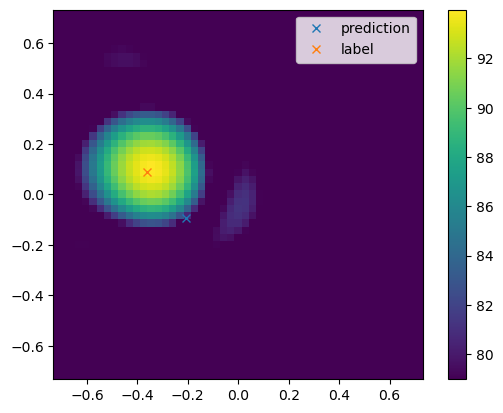

In [17]:
import matplotlib.pyplot as plt
from acoular import L_p

# use the first sample from the validation dataset
generator = validation.generate()
data = next(generator)
sourcemap = data['sourcemap']
sourcemap /= sourcemap.max()
prediction = model.predict(sourcemap)[0]

plt.figure()
plt.imshow(L_p(sourcemap.squeeze()).T,
            vmax=L_p(sourcemap.max()),
            vmin=L_p(sourcemap.max())-15,
            extent=validation.grid.extend(),
            origin="lower")
plt.plot(prediction[1],prediction[2],'x',label="prediction")
plt.plot(data['loc'][0],data['loc'][1],'x',label="label")
plt.colorbar()
plt.legend()